In [1]:
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/survey.csv')

with open("../data/mapping.txt", "r") as mapping_txt:
    mapping = mapping_txt.read()
mapping = eval(mapping)


def replace_mapping(df):
    blank = ['orig', 'split']
    task = df.task.astype(int).iloc[0]
    task_mapping = ['Notebook_' + i.lower() for i in mapping[task]]
    task_mapping = {m: blank[i] for i, m in enumerate(task_mapping)}
    df.value = df.value.replace(task_mapping)
    return df

In [3]:
df = df[df['ELECTRONIC CONSENT'] == 'Yes']
df = df.loc[:, ~df.columns.isin(['ELECTRONIC CONSENT'])]

In [4]:
mapping

[['A', 'B'], ['A', 'B'], ['A', 'B'], ['B', 'A'], ['B', 'A']]

### Experience description

In [5]:
exp = df.set_index("Timestamp").iloc[:, :2]
exp.columns = ['freq', 'experience']
exp = exp.reset_index()
exp.describe()

,experience
count,23.000000
mean,4.760870
std,2.835928
min,1.000000
25%,2.500000
50%,4.000000
75%,7.500000
max,10.000000


In [6]:
exp.freq.value_counts() / len(exp)

Less than once a week    0.434783
2-3 times a week         0.391304
Every day                0.173913
Name: freq, dtype: float64

### Evaluation description

In [7]:
tasks_raw = df.set_index("Timestamp").iloc[:, 2:]

new_columns = []
for i in range(5):
    new_columns.extend([f'{i}_Understanding', f'{i}_Preference', f'{i}_Other'])
tasks_raw.columns = new_columns
tasks = tasks_raw.reset_index().melt(id_vars=['Timestamp'])

In [8]:
tasks['task'] = tasks.variable.str.split('_').apply(lambda x: x[0])
tasks['question'] = tasks.variable.str.split('_').apply(lambda x: x[1])

In [9]:
understanding = tasks[tasks['question'] == 'Understanding']
understanding = understanding[['Timestamp','task','value']]
understanding.columns = ['Timestamp','task','understand']

In [10]:
preference = tasks[tasks['question'] == 'Preference']
preference = preference.groupby('task').apply(lambda x: replace_mapping(x))
preference['value'] = preference.value.replace({'The script': 'script'})

In [11]:
preference = preference.merge(exp, on = 'Timestamp')
preference = preference.merge(understanding, on = ['Timestamp','task'])
preference.understand = preference.understand.astype(int)
preference['value_coded'] = preference['value'].replace({'orig': 0, 'split': 1, 'script': 2})

In [12]:
preference = preference[preference['understand'] > 2]

In [13]:
preference.value.value_counts()

orig      70
split     33
script     9
Name: value, dtype: int64

In [14]:
preference

,Timestamp,variable,value,task,question,freq,experience,understand,value_coded
0,10/13/2021 15:11:42,0_Preference,orig,0,Preference,Every day,3.0,4,0
1,10/13/2021 15:11:42,1_Preference,split,1,Preference,Every day,3.0,3,1
2,10/13/2021 15:11:42,2_Preference,script,2,Preference,Every day,3.0,5,2
3,10/13/2021 15:11:42,3_Preference,split,3,Preference,Every day,3.0,5,1
4,10/13/2021 15:11:42,4_Preference,orig,4,Preference,Every day,3.0,5,0
...,...,...,...,...,...,...,...,...,...
110,11/1/2021 11:03:52,0_Preference,orig,0,Preference,2-3 times a week,2.0,4,0
111,11/1/2021 11:03:52,1_Preference,orig,1,Preference,2-3 times a week,2.0,4,0
112,11/1/2021 11:03:52,2_Preference,orig,2,Preference,2-3 times a week,2.0,5,0
113,11/1/2021 11:03:52,3_Preference,split,3,Preference,2-3 times a week,2.0,4,1


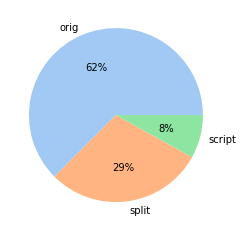

In [15]:
pie = (preference.value.value_counts() / len(preference)).reset_index()
data = pie.value.tolist()
labels = pie['index'].tolist()

colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%');

In [16]:
pie

,index,value
0,orig,0.625000
1,split,0.294643
2,script,0.080357


In [17]:
pref_for_log =  preference[preference.value != 'script']

In [18]:
expected, observed, stats = pg.chi2_independence(preference, x='value', y='freq')

In [19]:
expected, observed, stats = pg.chi2_independence(pref_for_log, x='value', y='task')

In [20]:
expected

task,0,1,2,3,4
value,,,,,
orig,14.271845,14.271845,11.553398,14.951456,14.951456
split,6.728155,6.728155,5.446602,7.048544,7.048544


In [21]:
observed

task,0,1,2,3,4
value,,,,,
orig,15,15,9,11,20
split,6,6,8,11,2


In [22]:
task_answer = preference.groupby(['task','value']).variable.count().reset_index()

In [23]:
task_size = preference.groupby(['task']).variable.count().reset_index()

In [24]:
task_answer = task_answer.merge(task_size, on = 'task', how = 'left')

In [25]:
task_answer['percent'] = task_answer.variable_x / task_answer.variable_y

In [26]:
task_answer

,task,value,variable_x,variable_y,percent
0,0,orig,15,22,0.681818
1,0,script,1,22,0.045455
2,0,split,6,22,0.272727
3,1,orig,15,22,0.681818
4,1,script,1,22,0.045455
5,1,split,6,22,0.272727
6,2,orig,9,23,0.391304
7,2,script,6,23,0.260870
8,2,split,8,23,0.347826
9,3,orig,11,22,0.500000
